In [1]:
!pip3 install torch torchvision

In [0]:
import torch
#torchvision is a standard package which contain lots of datasets include MNIST dataset.It also consists of transformations, transformations are commonly 
#applied to these images in order to pre-process them before fit into a neural network.
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F

In [3]:
#transforms.Compose means to chain transformations together. transforms.ToTensor() will convert the numpy array in the range of 0-255 to a float tensor in
#the range 0-1 encode in a tensor shape (Channel, Height, Width). transforms.Normalize() will normalized the values for each tensor of image size channel height
#and width. The first bracket is mean=0.5, second bracket is s.d.=0.5.
transform = transforms.Compose([
                                transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5])]) #Normalize, set value 0.5 since we want the range 0 - 1 change to range -1 - 1.

#In this MNIST dataset, each image is 28*28 grayscale image which means each image is 2D numpy array, it's 28 pixel wide and 28 pixel long, each pixel in the range 0-255.
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform = transform)#transform dictates any image manipulations that you wish to apply on the images.
#training_dataset

validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform = transform)

#loader image
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) 
#Since batch_size=100, we have total of 60000 training set, it will take roughly 600 iteration to complete one epoch. It will update the weight of neural network for each iteration to minimize the error.
#Remember to shuffle the training data before each epoch.

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False) #validation_loader is only for testing purposes, not have to 
#shuffle, since it's not use to train the model, it instead use for testing the model.

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
#Since we want to plot the image use matplotlib, we need to convert the image from tensor into numpy array.
#tensor.clone makes a new copy of the tensor. image.transpose(color channel, width, height), since this is grayscale image which only have one color,
#thus the color channel = 1, the shape now is (1,28,28). To plot the image, we required (28,28,1) shape. Thus swap the first one to be the last one...
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  #print(image.shape)
  
  #denormalize
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))  #normalize = (x-mean)/sd   denormalize = (x*sd)+mean
  image = image.clip(0,1) #previously, we have range between -1 and 1, now change the range between 0 and 1 use clip().
  return image



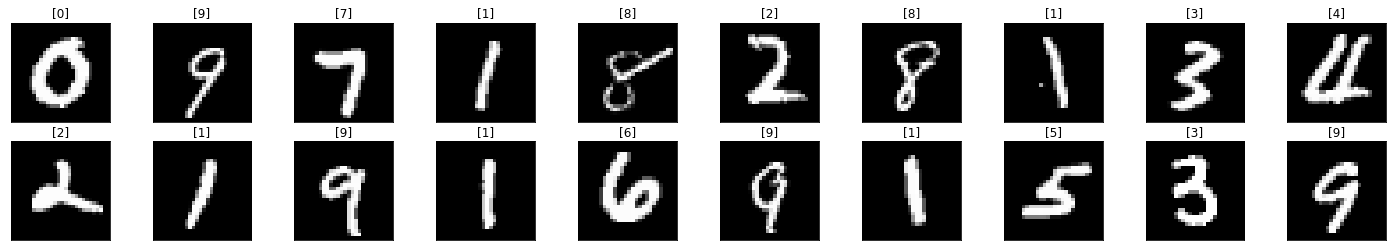

In [5]:
dataiter = iter(training_loader) 
images, labels = dataiter.next() ##Go through the training loader and access one element at a time by calling next(). Like it will grab the first batch of our training data. And split into images and labels for that training data.
fig = plt.figure(figsize=(25,4)) #specify the width and height of the figure.

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[]) #2 rows, 10 columns, start at index 1 which (idx+1).
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])


In [0]:
#Create Custom Model:
#Setting model constructor
class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out): #D_in:number of input nodes, H1 & H2: first and second hidden layers, D_out: number of output nodes.
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)  #input layer.
    self.linear2 = nn.Linear(H1, H2) #second layer
    self.linear3 = nn.Linear(H2, D_out) #third layer
  def forward(self, x):
    x = F.relu(self.linear1(x)) #relu() is similar to sigmoid() in previously used.
    x = F.relu(self.linear2(x))
    x = self.linear3(x) #return the raw output which is score, not probability, since we want use nn.CrossEntropy() to compute loss for our dataset after.
    return x


In [7]:
model = Classifier(784, 125, 65, 10)#arguments: input size(each image is 28*28 = 784), num of nodes in first & second hidden layer, output size(num of classes, in here we have 0-9 which 10 classes)
model



Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
#Loss function in our model
criterion = nn.CrossEntropyLoss() #This loss function used for multiclass classification.
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr is learning rater

In [9]:
#specify number of epochs
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.view(inputs.shape[0], -1) #note that the shape we have is (1, 28, 28), however due to the structure of neural network, we have to 
    #reshape to: (1, 784) where 1 is color channel, 784 is 28*28 which we flatten it for each image. In inputs.view(), -1 is total value of second index.
    outputs = model(inputs) #contain bunch of score values and it follows the class wich contains the highest score by passing it into the softmax.
    loss = criterion(outputs, labels) #Compare predicted outputs and labels and determine error base on CrossEntropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1) #preds is return the index of the maximum value for that image.
    running_loss += loss.item() #The current loss at batch iteration
    running_corrects += torch.sum(preds == labels.data) #See how many got correct


  else: #the else statement will start after for loop finish which means we iterated through every single batch of images.
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
         val_inputs = val_inputs.view(val_inputs.shape[0], -1)
         val_outputs = model(val_inputs)
         val_loss = criterion(val_outputs, val_labels)

         _, val_preds = torch.max(val_outputs, 1)
         val_running_loss += val_loss.item() 
         val_running_corrects += torch.sum(val_preds == val_labels.data)
   
    
  
  







    epoch_loss = running_loss/len(training_loader) #print accumulated loss that's compute for the entire dataset at the specific epoch. Average loss for epoch
    #len(training_loader) = 600. 
    epoch_acc = running_corrects.float()/len(training_loader) #average accuracy for that epoch
    running_loss_history.append(epoch_loss) #Since keep track loss in every single epoch
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))


epoch : 1
training loss: 0.9060, acc 79.4200
validation loss: 0.4129, validation acc 88.9200
epoch : 2
training loss: 0.3725, acc 89.3850
validation loss: 0.3257, validation acc 90.5800
epoch : 3
training loss: 0.3131, acc 90.9550
validation loss: 0.2831, validation acc 91.8500
epoch : 4
training loss: 0.2810, acc 91.8333
validation loss: 0.2604, validation acc 92.5600
epoch : 5
training loss: 0.2563, acc 92.6300
validation loss: 0.2386, validation acc 93.1300
epoch : 6
training loss: 0.2363, acc 93.2183
validation loss: 0.2257, validation acc 93.3600
epoch : 7
training loss: 0.2173, acc 93.6700
validation loss: 0.2072, validation acc 93.9300
epoch : 8
training loss: 0.2009, acc 94.3050
validation loss: 0.1982, validation acc 94.0600
epoch : 9
training loss: 0.1864, acc 94.6083
validation loss: 0.1800, validation acc 94.7100
epoch : 10
training loss: 0.1732, acc 95.0383
validation loss: 0.1695, validation acc 94.9000
epoch : 11
training loss: 0.1619, acc 95.3183
validation loss: 0.1612

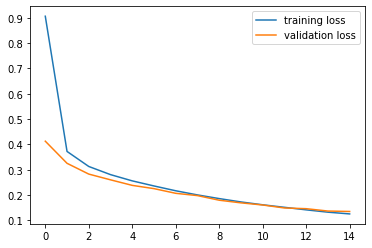

In [10]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

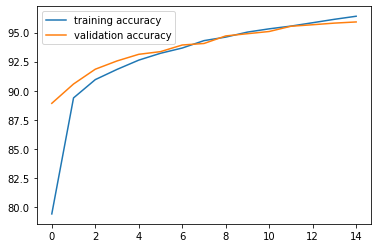

In [11]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()

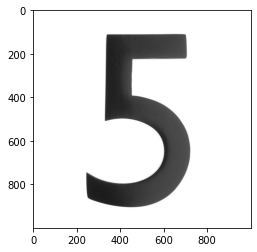

In [12]:
#Test our model by grab a image from the web
import requests
from PIL import Image #PIL is Python Image Library
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url,stream=True) #retrieve image
img = Image.open(response.raw) #identify the raw contents of the response variable
plt.imshow(img)
#print(response)

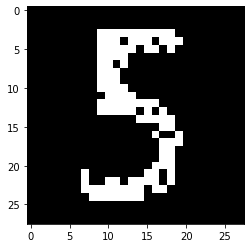

In [13]:
#We need to preprocess image before fit into the model, since our model only recognize image in 28*28 black background with white color digits.
import PIL.ImageOps 
img = PIL.ImageOps.invert(img) #invert the color of the image, image then become black background, white foreground.
img = img.convert('1') #Also, since the image from web is a RGB format with 3 channel pixwl intensity values instead of grayscale image.
img = transform(img) #Inside transform there is a resize which change the range of image to 28*28.
plt.imshow(im_convert(img))

In [14]:
img = img.view(img.shape[0], -1) #pass image into our model
output = model(img) #result a score
_, pred = torch.max(output, 1) #take class with highest score
print(pred.item())


5


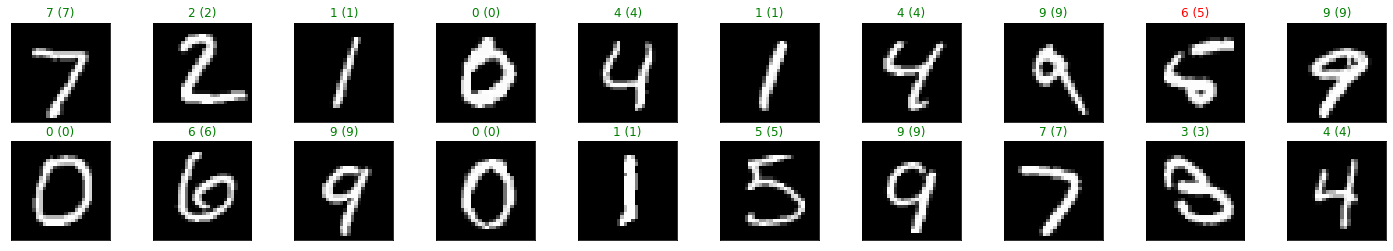

In [15]:
dataiter = iter(validation_loader) 
images, labels = dataiter.next() 
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[]) #2 rows, 10 columns, start at index 1 which (idx+1).
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx] == labels[idx] else "red"))